# Functional basis
Functional bases are useful for studying weighted addition because the output signals are known to be some combination of the inputs. The basis of original inputs is finite. As long as the basis signals are linearly separable, the multiple weights imparted by the weight bank can be decomposed from just one measurement. Furthermore, this is all very low noise because a weight is determined by an average over an entire oscilloscope window. Things that are **not** part of the basis, such as noise power and distortion, can be pulled out as remainders and studied.

In this notebook, we make some signals and noise, and some mixures of those signals. We make a full basis of all

In [1]:
# Reload modules every time code is called. Set autoreload 0 to disable
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

import lightlab.util.data as dUtil
from lightlab.util.data import FunctionalBasis, Waveform, FunctionBundle
import lightlab.applevel.bss as bss

## Initial signals

In [2]:
# Make some simple signals
t = np.linspace(0,1,300)
# noi1 = Waveform(t, .05 * np.random.randn(len(t))) # pseudo-noise
noi1 = Waveform(t, .1 * np.sin(2*np.pi*50*t))
sou1 = Waveform(t, np.sin(2*np.pi*2*t) * np.sin(2*np.pi*10*t))
sou2 = Waveform(t, np.cos(2*np.pi*5*t) + 0*np.sign(t%.2 - .1)) + noi1
# Mixtures
rec1 = .9 * sou1 - .6 * sou2
rec2 = .1 * sou1 + .8 * sou2
# Other signal
rec3 = Waveform(t, .4 * np.sin(25*t)) - .5*noi1 

# High sampling rate signals
# t = np.linspace(0,1, 10000)
# n1 = Waveform(t, .05 * np.random.randn(len(t))) # pseudo-noise
# s3 = Waveform(t, .05 * np.random.randn(len(t))) # pseudo-noise
# carrierFreq = 8
# modFreq = 2
# s1 = Waveform(t, np.sin(2*np.pi*carrierFreq*t) * (1 + np.cos(2*np.pi*modFreq*t)) / 2)
# s2 = Waveform(t, np.sin(2*np.pi*carrierFreq*t))

## Create signal basis

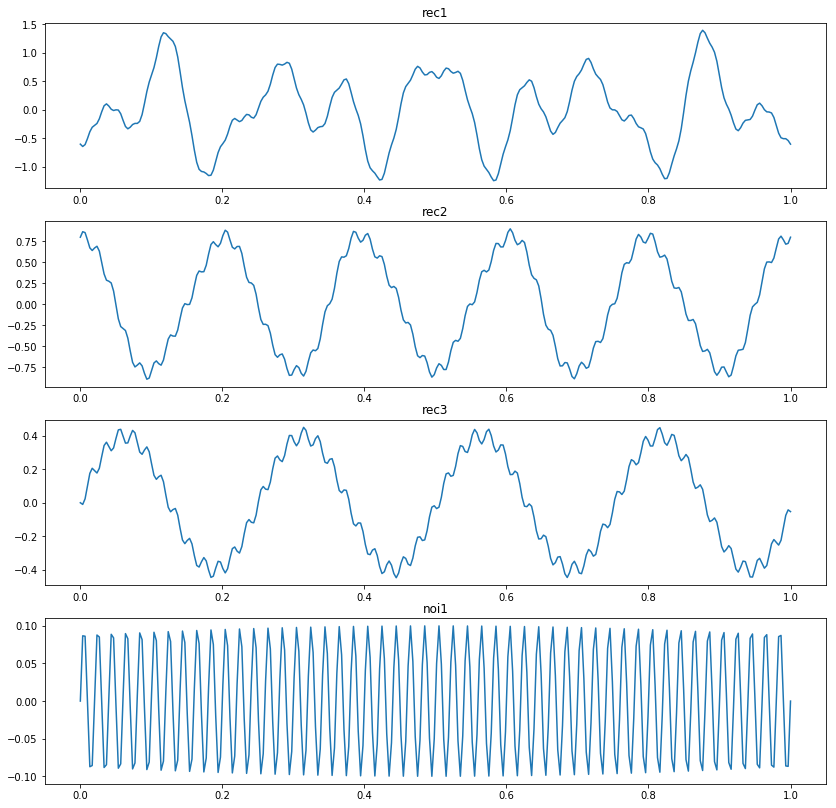

In [3]:
# bTest only contains s1 and s2, while bFull has everything
bTest = FunctionalBasis([rec1,rec2])
bFull = FunctionalBasis([rec1,rec2,rec3,noi1])
for i,ax in enumerate(bFull.multiAxisPlot()):
    ax.set_title(['rec1', 'rec2', 'rec3', 'noi1'][i])

In [4]:
# makes a trial function based on weighted addition of the full basis
# decompose limited basis and look at remainder
# then decompose the remainder in the full basis
def trial(weights):
    tfun = bFull.weightedAddition(weights)
#     print(tfun.ordi.shape)
    tfun.simplePlot()
    dec = bTest.decompose(tfun)
    bTest.weightedAddition(dec).simplePlot()
    for i in range(len(dec)):
        print('Weight {}: actual {:2.3f}, test decomposed {:2.3f}'.format(i, weights[i], dec[i]))
        
    rfun = bTest.remainder(tfun)
#     rfun.simplePlot()
    
    fullDec = bFull.decompose(rfun)
    print()
    for i in range(len(fullDec)):
        print('Remainder {}: {:2.3f}'.format(i, fullDec[i]))

Weight 0: actual -0.700, test decomposed -0.703
Weight 1: actual 0.500, test decomposed 0.524

Remainder 0: 0.003
Remainder 1: -0.024
Remainder 2: -2.000
Remainder 3: 1.000


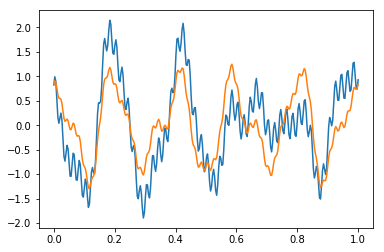

In [5]:
# try it yourself by entering weights for rec1,2,3, and noi1
trial(np.array([-.7,.5,-2,1]))

## Component analysis
Methods for computing the principal components and independent components of the full basis. They use the SVD methods that are typical of digital processors.

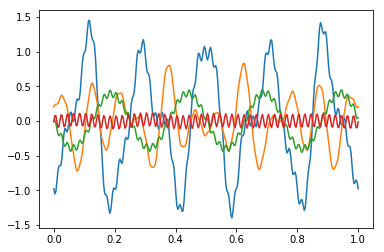

In [6]:
bFull.componentAnalysis(pcaIca=True).simplePlot()

And here are the independent components

/Users/atait/Dropbox/Documents/gitProjects/experiment-code/calibration-instrumentation/venv/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


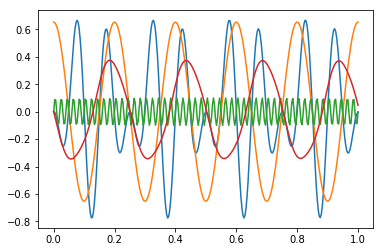

In [7]:
bFull.componentAnalysis(pcaIca=False).simplePlot()

## Doing PCA and ICA using moment fitting

**! You can pass any FunctionalBasis as an argument to pcaActu (see BSS demo) !**

It does some weighted additions and averaging to find an epitrochoid

(array([[ 0.43435822, -0.3814903 ],
       [ 0.08767025,  0.09981982]]), <lightlab.applevel.bss.Epitrochoid object at 0x1127e8fd0>, array([[1.93721497, 0.70819484],
       [0.70819484, 2.12155638]]))
q = [0.35547778 0.22262422]
phi = 5.562498


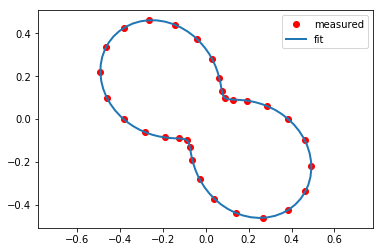

In [8]:
# measure the second moments around the unit circle
momFun = bss.pcaActu(bTest, nPts=30, radius=1.)
pcaSpec = bss.pcaProc(momFun)

# fit and plot the resulting shape
cartCoords = bss.polarToWeights(*momFun.getData())
plt.plot(cartCoords[:,0], cartCoords[:,1], 'ro', label='measured')
epi = pcaSpec[1]
epi.plot(isPolar=False, label='fit')
plt.axis('equal')
plt.legend()
print(pcaSpec)
pcaSpec[1].print()

### Comparison of measured PC signals to real ones
Now we know what the PC vectors are. Go to them, do weighted addition. Do we recover the actual principal component signals, found by SVD?

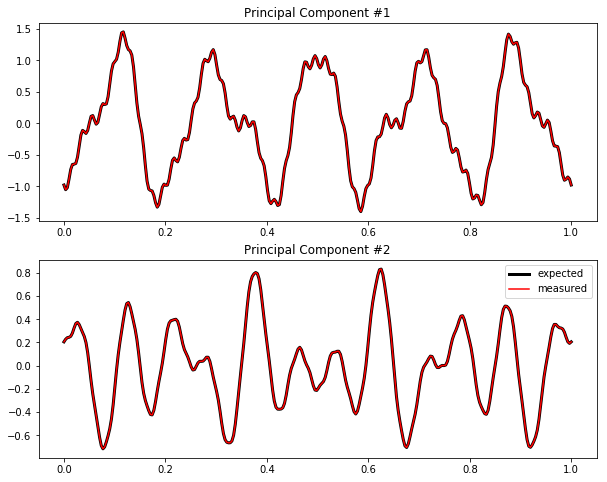

In [9]:
# do weighted addition at the pc vectors to get the pc basis signals
pcVecs = pcaSpec[0]
measPc = dUtil.FunctionalBasis()
for i, pcV in enumerate(pcVecs):
#     print(pcV, 'is pcvec', i+1)
    measPc.addDim(bTest.weightedAddition(pcV / np.linalg.norm(pcV)))

expPc = bTest.componentAnalysis(pcaIca=True)
expPc = expPc.correctSigns(measPc, maintainOrder=True)

# plotting
fi, ax = plt.subplots(nrows=2, figsize=(10,8))
axList = expPc.multiAxisPlot(ax, 'k', lw=3, label='expected', titleRoot='Principal Component #{}')
measPc.multiAxisPlot(axList, 'r', label='measured')
plt.legend()

## Blind source separation
Here we are going to recover, not the received signals rec1, rec2, rec3, but instead the original sources sou1 and sou2.

First measure the fourth moment around the transformed angle, fit the epitrochoid. The green circle is relative kurtosis of 3, meaning Gaussian

We got super-gaussian; [ 2.16694426  0.36505347 -0.27447668]
q = [ 2.16694426 -0.36505347 -0.27447668]
phi = 2.008703


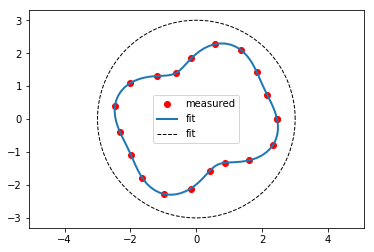

In [10]:
mom4Fun, pcaSpec = bss.bssActu(bTest, nPts=20, radius=1.)
bssSpec = bss.bssProc(mom4Fun, pcaSpec)
epi4 = bssSpec[2]
bssSpec[2].print()

cartCoords = bss.polarToWeights(*mom4Fun.getData())
plt.plot(cartCoords[:,0], cartCoords[:,1], 'ro', label='measured')
epi4.plot(label='fit')
plt.axis('equal')
plt.legend()

### Comparison of measured ICA signals to real ones
Now we know what the IC vectors are. Go to them, do weighted addition.

We should find what we expect from SVD, which should also be the ``sou`` signals

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1133b7dd8>,
      dtype=object)

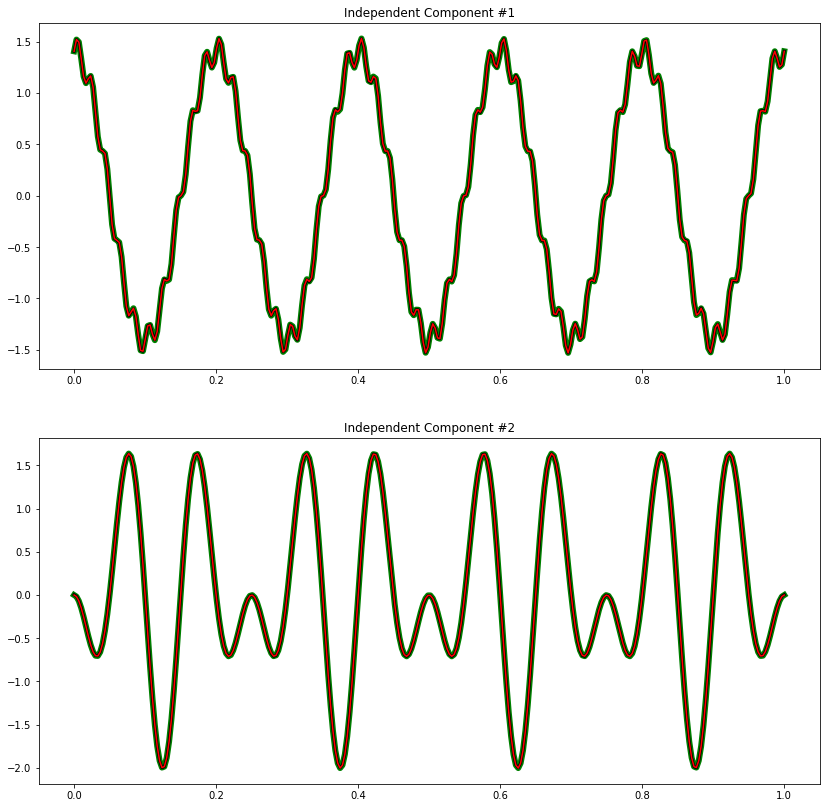

In [11]:
# weighted addition
measIc = dUtil.FunctionBundle()
icVecs = bssSpec[0]
for _, icV in enumerate(icVecs):
#     print(icV, 'is icvec')
    measIc.addDim(bTest.weightedAddition(icV).unitRms())

# SVD
expIc = bTest.componentAnalysis(pcaIca=False)
expIc = expIc.correctSigns(measIc, maintainOrder=False).unitRms()

# sources
souBas = FunctionalBasis([sou1, sou2]).correctSigns(measIc, maintainOrder=False).unitRms()

# plotting
axList = souBas.multiAxisPlot(None, 'g', lw=6, titleRoot='Independent Component #{}')
axList = expIc.multiAxisPlot(axList, 'k', lw=3)
measIc.multiAxisPlot(axList, 'r')